In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ascii_files = glob.glob('*ASC*')
ascii_files

['example_ASC.TXT',
 'gb-long_2016-08-24_0_000_ASC.TXT',
 'gb-long_2016-08-24_0_001_ASC.TXT']

In [3]:
columns = ['datetime', 'ensemble_number', 'number_of_ensembles', 
           'pitch', 'roll', 'corrected_heading', 'adcp_temp']
columns += ['v_bt_x', 'v_bt_y', 'v_bt_z', 'v_bt_err', 
            'depth_snd', 'gga_alt', 'gga_dalt', 'gga_hdop',
            'depth_beam1', 'depth_beam2', 'depth_beam3', 'depth_beam4']
columns += ['total_elapsed_dist', 'total_elapsed_time', 'total_dist_n', 'total_dist_e', 'total_dist_mg']
columns += ['lat', 'lon', 'invalid', 'fixed_value_not_used']
columns += ['Q_middle', 'Q_top', 'Q_bot', 
            'start_shore_dist_est', 'start_dist', 'end_shore_dist_est', 'end_dist',
            'start_depth', 'end_depth']
columns += ['nbins', 'unit', 'vel_ref', 'intensity_units', 'intensity_scale_fac', 'sound_abs_fac']
columns

['datetime',
 'ensemble_number',
 'number_of_ensembles',
 'pitch',
 'roll',
 'corrected_heading',
 'adcp_temp',
 'v_bt_x',
 'v_bt_y',
 'v_bt_z',
 'v_bt_err',
 'depth_snd',
 'gga_alt',
 'gga_dalt',
 'gga_hdop',
 'depth_beam1',
 'depth_beam2',
 'depth_beam3',
 'depth_beam4',
 'total_elapsed_dist',
 'total_elapsed_time',
 'total_dist_n',
 'total_dist_e',
 'total_dist_mg',
 'lat',
 'lon',
 'invalid',
 'fixed_value_not_used',
 'Q_middle',
 'Q_top',
 'Q_bot',
 'start_shore_dist_est',
 'start_dist',
 'end_shore_dist_est',
 'end_dist',
 'start_depth',
 'end_depth',
 'nbins',
 'unit',
 'vel_ref',
 'intensity_units',
 'intensity_scale_fac',
 'sound_abs_fac']

In [4]:
df_cols = ['depth', 'vmag', 'vdir', 'vx', 'vy', 'vz', 'verr', 'bs1', 'bs2', 'bs3', 'bs4', 'pctg', 'Q']

In [5]:
def parse_header(f):
    row1 = next(f).strip().split()
    row1[0] = '20' + row1[0] if '20' not in row1[0] else row1[0]
    dt = pd.datetime(*tuple(map(int, row1[:6])), int(int(row1[6]) * 1e4))
    dt64 = np.datetime64(dt)
    ensemble_number, ne = map(int, row1[7:9])

    data = [dt] + [ensemble_number, ne] + list(map(float, row1[9:]))
    for i in range(4):
        data += list(map(float, next(f).strip().split()))
    row6 = next(f).strip().split()
    nbins = int(row6[0])
    data += row6[1:4]
    data += list(map(float, row6[4:]))
    return ensemble_number, data, nbins, dt

def ascii2pd(ascii_file, make_geometries=False):
    f = open(ascii_file)
    while True:
        line = next(f).strip().split()
        if len(line) == 0:
            continue
        else:
            break
    file_info = map(int, line)
    depth_cell_len, blank_after_transmit, adcp_depth_from_cn, n_depth_cells, n_pings, dt, mode = file_info
    
    data = {}
    dfs = {}
    
    try:
        while True:
            n, d, nbins, dt = parse_header(f)
            data[n] = d
            df = pd.DataFrame([map(float, next(f).strip().split()) for b in range(nbins)], columns=df_cols)
            #df.index = df.depth
            dfs[dt] = df
    except StopIteration:
        pass
    
    df = pd.DataFrame.from_dict(data, orient='index')
    df.columns = columns
    df.index = pd.to_datetime(df.datetime)

    if make_geometries:
        df['geometry'] = [Point(r.lon, r.lat) for i, r in df.iterrows()]
        df['geometry'] = projectdf(df, '+init=epsg:4269', '+init=epsg:26715')
        df['X'] = [p.x for p in df.geometry]
        df['Y'] = [p.y for p in df.geometry]
    else:
        df['X'] = df.lon
        df['Y'] = df.lat
    
    # make a data panel of the velocity data
    pn = pd.Panel(dfs)
    return df, pn

def stack(df, pn, vmin, vmax, freq, make_geometries=False):
    pnr = pn.dropna(axis=1, how='all').resample(freq, axis=0).mean().copy()

    inds = (pnr.ix[:, :, 'vx'].values < vmin) | (pnr.ix[:, :, 'vx'].values > vmax)
    pnrs = pnr.copy()
    pnrs.ix[:, :, 'vx'].mask(inds, inplace=True)
    pnrs.ix[:, :, 'vy'].mask(inds, inplace=True)

    dfr = df[['X', 'Y', 'datetime']].resample(freq).mean()
    if make_geometries:
        dfr['geometry'] = [Point(r.X, r.Y) for i, r in dfr.iterrows()]
    dfr['vx'] = pnrs.ix[:, :, 'vx'].mean()
    dfr['vy'] = pnrs.ix[:, :, 'vy'].mean()
    dfr.dropna(axis=0, inplace=True)
    return dfr

In [6]:
outpath = 'output'
if not os.path.isdir(outpath):
    os.makedirs(outpath)

for ascii_file in ascii_files:
    if os.path.getsize(ascii_file) == 0:
        continue
    print(ascii_file)
    df, pn = ascii2pd(ascii_file)
    dfr = stack(df, pn, vmin=-1000, vmax=1000, freq='10s')

example_ASC.TXT
gb-long_2016-08-24_0_000_ASC.TXT
gb-long_2016-08-24_0_001_ASC.TXT


### Dataframe of header information

In [7]:
df.head()

,datetime,ensemble_number,number_of_ensembles,pitch,roll,corrected_heading,adcp_temp,v_bt_x,v_bt_y,v_bt_z,...,start_depth,end_depth,nbins,unit,vel_ref,intensity_units,intensity_scale_fac,sound_abs_fac,X,Y
datetime,,,,,,,,,,,,,,,,,,,,,
2016-08-24 18:26:45.850,2016-08-24 18:26:45.850,13701,1,-2.85,-0.62,189.63,24.14,-21.21,-153.72,-0.2,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000056,44.548883
2016-08-24 18:26:46.430,2016-08-24 18:26:46.430,13702,1,-2.96,-0.72,190.82,24.16,-27.47,-152.76,0.2,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000058,44.548874
2016-08-24 18:26:47.010,2016-08-24 18:26:47.010,13703,1,-1.28,-0.79,191.41,24.14,-31.29,-160.07,1.9,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000059,44.548865
2016-08-24 18:26:47.590,2016-08-24 18:26:47.590,13704,1,-2.37,-1.49,191.71,24.18,-26.32,-165.91,2.9,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000061,44.548856
2016-08-24 18:26:48.170,2016-08-24 18:26:48.170,13705,1,-1.70,-0.97,193.38,24.15,-35.79,-161.71,1.9,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000063,44.548848


In [8]:
df.columns

Index(['datetime', 'ensemble_number', 'number_of_ensembles', 'pitch', 'roll',
       'corrected_heading', 'adcp_temp', 'v_bt_x', 'v_bt_y', 'v_bt_z',
       'v_bt_err', 'depth_snd', 'gga_alt', 'gga_dalt', 'gga_hdop',
       'depth_beam1', 'depth_beam2', 'depth_beam3', 'depth_beam4',
       'total_elapsed_dist', 'total_elapsed_time', 'total_dist_n',
       'total_dist_e', 'total_dist_mg', 'lat', 'lon', 'invalid',
       'fixed_value_not_used', 'Q_middle', 'Q_top', 'Q_bot',
       'start_shore_dist_est', 'start_dist', 'end_shore_dist_est', 'end_dist',
       'start_depth', 'end_depth', 'nbins', 'unit', 'vel_ref',
       'intensity_units', 'intensity_scale_fac', 'sound_abs_fac', 'X', 'Y'],
      dtype='object')

### panel of backscatter data

In [9]:
pn.axes

[DatetimeIndex(['2016-08-24 18:26:45.850000', '2016-08-24 18:26:46.430000',
                '2016-08-24 18:26:47.010000', '2016-08-24 18:26:47.590000',
                '2016-08-24 18:26:48.170000', '2016-08-24 18:26:48.750000',
                '2016-08-24 18:26:49.330000', '2016-08-24 18:26:49.910000',
                '2016-08-24 18:26:50.490000', '2016-08-24 18:26:51.070000',
                ...
                '2016-08-24 20:38:52.820000', '2016-08-24 20:38:53.410000',
                       '2016-08-24 20:38:54', '2016-08-24 20:38:54.580000',
                '2016-08-24 20:38:55.170000', '2016-08-24 20:38:55.760000',
                '2016-08-24 20:38:56.350000', '2016-08-24 20:38:56.940000',
                '2016-08-24 20:38:57.530000', '2016-08-24 20:38:58.130000'],
               dtype='datetime64[ns]', length=13477, freq=None),
 RangeIndex(start=0, stop=26, step=1),
 Index(['depth', 'vmag', 'vdir', 'vx', 'vy', 'vz', 'verr', 'bs1', 'bs2', 'bs3',
        'bs4', 'pctg', 'Q'],
      

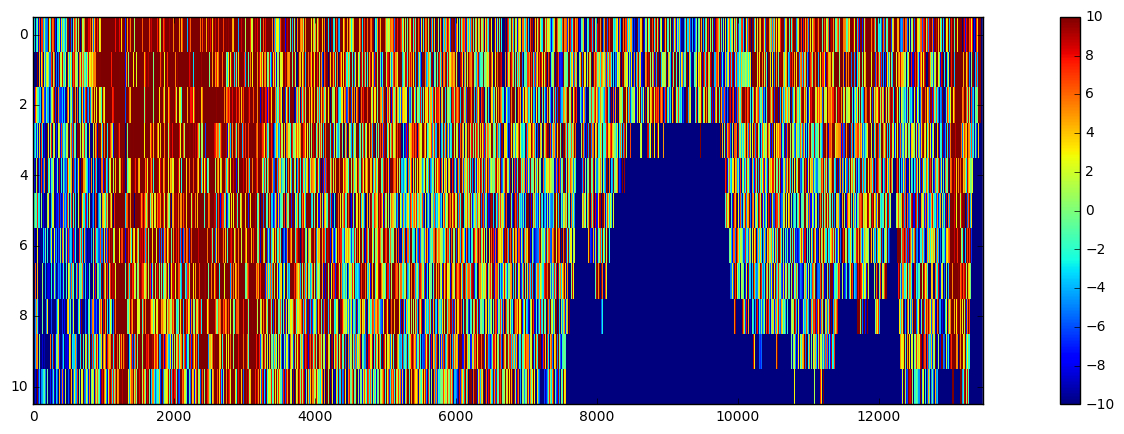

In [10]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(pn.ix[:, :10., 'vy'], vmin=-10, vmax=10, interpolation='None')
plt.gca().set_aspect(500)
plt.colorbar()

### process single ADCP panel

In [11]:
vmin, vmax = -1000, 1000 # valid range of velocities
freq = '10s' # resampling frequency

pnr = pn.dropna(axis=1, how='all').resample(freq, axis=0).mean().copy()

inds = (pnr.ix[:, :, 'vx'].values < vmin) | (pnr.ix[:, :, 'vx'].values > vmax)
pnrs = pnr.copy()
pnrs.ix[:, :, 'vx'].mask(inds, inplace=True)
pnrs.ix[:, :, 'vy'].mask(inds, inplace=True)

In [12]:
bs = pnr.ix[:, :10, ['bs1', 'bs2', 'bs3', 'bs4']].mean(axis=2)
bs = pn.ix[:, :10, ['bs1', 'bs2', 'bs3', 'bs4']].mean(axis=2)
bs.head()

,2016-08-24 18:26:45.850000,2016-08-24 18:26:46.430000,2016-08-24 18:26:47.010000,2016-08-24 18:26:47.590000,2016-08-24 18:26:48.170000,2016-08-24 18:26:48.750000,2016-08-24 18:26:49.330000,2016-08-24 18:26:49.910000,2016-08-24 18:26:50.490000,2016-08-24 18:26:51.070000,...,2016-08-24 20:38:52.820000,2016-08-24 20:38:53.410000,2016-08-24 20:38:54,2016-08-24 20:38:54.580000,2016-08-24 20:38:55.170000,2016-08-24 20:38:55.760000,2016-08-24 20:38:56.350000,2016-08-24 20:38:56.940000,2016-08-24 20:38:57.530000,2016-08-24 20:38:58.130000
0,83.650,83.650,84.075,83.65,83.850,83.550,83.225,84.100,83.425,83.025,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,83.8,83.925
1,84.900,85.425,85.650,85.00,85.675,85.550,85.100,85.550,85.425,85.125,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.000
2,85.125,85.350,85.450,84.90,85.225,85.475,85.475,85.100,85.125,85.150,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.000
3,84.825,84.800,84.900,84.50,85.775,84.900,84.800,84.900,84.700,84.300,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.000
4,84.100,84.100,83.975,83.95,86.025,83.650,83.975,83.525,83.650,83.550,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.000


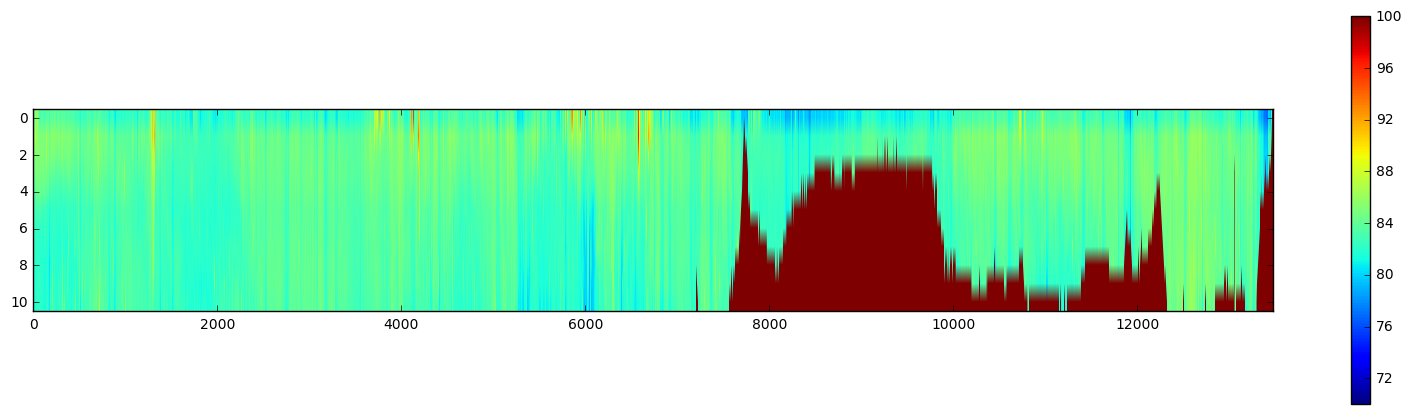

In [13]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(bs, vmin=70, vmax=100)
plt.gca().set_aspect(200)
plt.colorbar()

### Plot velocity component across panel

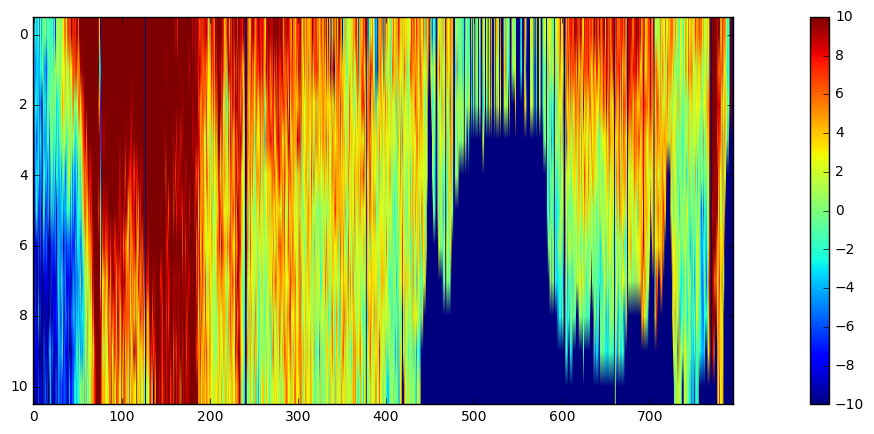

In [14]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(pnr.ix[:, :10, 'vy'], vmin=-10, vmax=10)
plt.gca().set_aspect(40)
plt.colorbar()

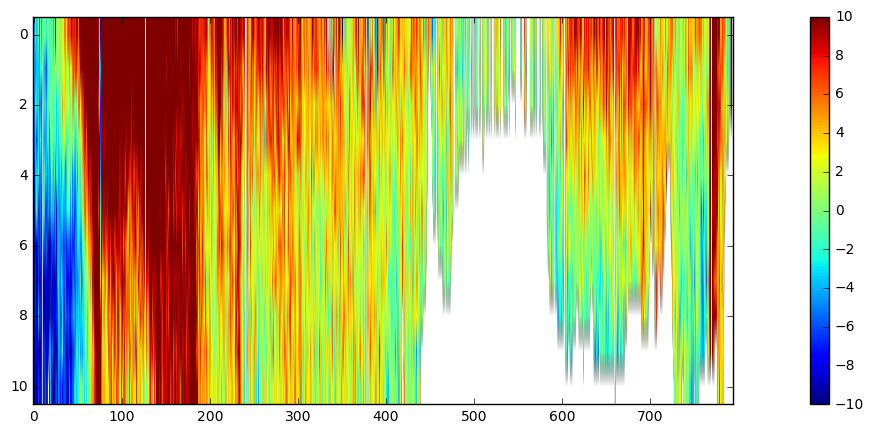

In [15]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(pnrs.ix[:, :10, 'vy'], vmin=-10, vmax=10)
plt.gca().set_aspect(40)
plt.colorbar()

### Slice panel to get dataframe of single measurement

In [16]:
pn.ix[:'2016-08-24 19', :, 'vy']

,2016-08-24 18:26:45.850000,2016-08-24 18:26:46.430000,2016-08-24 18:26:47.010000,2016-08-24 18:26:47.590000,2016-08-24 18:26:48.170000,2016-08-24 18:26:48.750000,2016-08-24 18:26:49.330000,2016-08-24 18:26:49.910000,2016-08-24 18:26:50.490000,2016-08-24 18:26:51.070000,...,2016-08-24 19:59:54.190000,2016-08-24 19:59:54.830000,2016-08-24 19:59:55.470000,2016-08-24 19:59:56.110000,2016-08-24 19:59:56.750000,2016-08-24 19:59:57.390000,2016-08-24 19:59:58.030000,2016-08-24 19:59:58.670000,2016-08-24 19:59:59.310000,2016-08-24 19:59:59.950000
0,9.4,-22.8,-9.9,-21.0,-7.5,6.0,-13.3,-17.2,-20.7,-0.1,...,-5.8,7.0,-32768.0,12.9,-21.5,19.6,-0.7,-5.1,0.0,-2.6
1,-5.0,-7.9,-5.4,-14.6,5.9,-5.5,-8.0,2.5,-3.0,10.7,...,0.3,6.2,-32768.0,0.6,-8.9,1.3,19.1,-2.1,6.9,-12.3
2,4.1,-11.1,3.3,-6.9,-3.5,-11.8,-9.9,3.1,-1.6,-8.9,...,7.2,2.9,-32768.0,0.8,-11.2,5.2,16.2,11.9,-8.2,-3.8
3,-3.9,-12.4,5.2,-6.1,-8.5,0.9,-4.2,-0.4,-8.8,-5.9,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
4,-3.3,-12.4,-5.8,-8.0,-26.9,7.2,-20.8,11.8,-9.7,-22.7,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
5,-10.7,-7.3,-4.4,-6.9,-13.4,-9.4,-14.9,-16.8,-26.0,-1.5,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
6,-3.4,-22.9,-10.8,-4.4,-21.3,-3.5,3.5,-5.1,-14.8,-7.4,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
7,-2.8,-9.9,-2.7,-3.5,-20.2,-18.8,-9.9,-16.1,-24.7,-9.8,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
8,-4.0,-14.2,-16.8,-18.5,-19.7,-15.3,4.5,-3.1,-25.0,-7.8,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
9,-12.6,-3.4,1.8,-17.1,-20.8,-7.1,-12.8,-16.1,-15.3,-3.5,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0


### reduce backscatter panel to dataframe 

In [17]:
dfall = pn.swapaxes(0, 2).to_frame()
dfall.index.levels[0].name = 'depth_bin'
dfall.index.levels[1].name = 'datetime'
dfall.head()

depth   vmag    vdir   vx    vy   vz  verr  \
depth_bin datetime                                                              
0         2016-08-24 18:26:45.850   1.38  13.58   46.25  9.8   9.4 -6.6 -11.0   
          2016-08-24 18:26:46.430   1.38  24.85  156.81  9.8 -22.8 -2.3   1.6   
          2016-08-24 18:26:47.010   1.38  12.63  141.91  7.8  -9.9 -5.1   1.4   
          2016-08-24 18:26:47.590   1.38  21.00  180.45 -0.2 -21.0 -4.5   7.4   
          2016-08-24 18:26:48.170   1.38   8.84  147.92  4.7  -7.5 -1.1 -11.7   

                                    bs1   bs2   bs3   bs4   pctg             Q  
depth_bin datetime                                                              
0         2016-08-24 18:26:45.850  86.2  84.1  81.9  82.4  100.0  2.147484e+09  
          2016-08-24 18:26:46.430  85.8  84.5  81.9  82.4  100.0 -6.000000e-02  
          2016-08-24 18:26:47.010  87.1  82.8  81.9  84.5  100.0 -5.000000e-02  
          2016-08-24 18:26:47.590  86.6  83.7  81.1  83.2  100.0 -2.000000e-02  
          2016-08-24 18:26:48.170  86.2  84.5  81.9  82.8  100.0 -3.000000e-02

### write dataframe to csv and then read it back in

In [18]:
dfall.to_csv('alldata.csv')

In [19]:
dfall2 = pd.read_csv('alldata.csv')

In [20]:
dfall2.head()

,depth_bin,datetime,depth,vmag,vdir,vx,vy,vz,verr,bs1,bs2,bs3,bs4,pctg,Q
0,0,2016-08-24 18:26:45.850,1.38,13.58,46.25,9.8,9.4,-6.6,-11.0,86.2,84.1,81.9,82.4,100.0,2.147484e+09
1,0,2016-08-24 18:26:46.430,1.38,24.85,156.81,9.8,-22.8,-2.3,1.6,85.8,84.5,81.9,82.4,100.0,-6.000000e-02
2,0,2016-08-24 18:26:47.010,1.38,12.63,141.91,7.8,-9.9,-5.1,1.4,87.1,82.8,81.9,84.5,100.0,-5.000000e-02
3,0,2016-08-24 18:26:47.590,1.38,21.00,180.45,-0.2,-21.0,-4.5,7.4,86.6,83.7,81.1,83.2,100.0,-2.000000e-02
4,0,2016-08-24 18:26:48.170,1.38,8.84,147.92,4.7,-7.5,-1.1,-11.7,86.2,84.5,81.9,82.8,100.0,-3.000000e-02


### write csv of header information

In [21]:
df.to_csv('header_info.csv', index=False) # write it without the index, since it duplicates the datetime column

In [22]:
df

,datetime,ensemble_number,number_of_ensembles,pitch,roll,corrected_heading,adcp_temp,v_bt_x,v_bt_y,v_bt_z,...,start_depth,end_depth,nbins,unit,vel_ref,intensity_units,intensity_scale_fac,sound_abs_fac,X,Y
datetime,,,,,,,,,,,,,,,,,,,,,
2016-08-24 18:26:45.850,2016-08-24 18:26:45.850,13701,1,-2.85,-0.62,189.63,24.14,-21.21,-153.72,-0.2,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000056,44.548883
2016-08-24 18:26:46.430,2016-08-24 18:26:46.430,13702,1,-2.96,-0.72,190.82,24.16,-27.47,-152.76,0.2,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000058,44.548874
2016-08-24 18:26:47.010,2016-08-24 18:26:47.010,13703,1,-1.28,-0.79,191.41,24.14,-31.29,-160.07,1.9,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000059,44.548865
2016-08-24 18:26:47.590,2016-08-24 18:26:47.590,13704,1,-2.37,-1.49,191.71,24.18,-26.32,-165.91,2.9,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000061,44.548856
2016-08-24 18:26:48.170,2016-08-24 18:26:48.170,13705,1,-1.70,-0.97,193.38,24.15,-35.79,-161.71,1.9,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000063,44.548848
2016-08-24 18:26:48.750,2016-08-24 18:26:48.750,13706,1,-2.24,-0.31,188.64,24.15,-18.81,-163.73,0.9,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000064,44.548842
2016-08-24 18:26:49.330,2016-08-24 18:26:49.330,13707,1,-2.15,-1.18,190.76,24.15,-26.27,-166.63,2.8,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000066,44.548830
2016-08-24 18:26:49.910,2016-08-24 18:26:49.910,13708,1,-2.34,-1.00,193.65,24.15,-31.84,-165.87,-1.0,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000067,44.548824
2016-08-24 18:26:50.490,2016-08-24 18:26:50.490,13709,1,-2.29,-0.41,189.68,24.14,-20.47,-173.53,-1.3,...,0.0,1.38,7.38,cm,BT,dB,0.43,0.074,-88.000068,44.548815
